# Credit card fraud detector

In this solution we will build the core of a credit card fraud detection system locally. We will start by training an anomaly detection algorithm, then proceed to train two XGBoost models for supervised training. To deal with the highly unbalanced data common in fraud detection, our first model will use re-weighting of the data, and the second will use re-sampling, using the popular SMOTE technique for oversampling the rare fraud data.

Our solution includes an example of making calls to a REST API to simulate a real deployment, using ```FastAPI``` to trigger both the anomaly detection and XGBoost model.

## Set up environment

In [5]:
import os
import numpy as np
import zipfile
from definitions import *
from dotenv import load_dotenv
load_dotenv()

/home/goamegah/Documents/workspace/develop/esgi/4a/pa/realtime-fraud-detection/dataset


ModuleNotFoundError: No module named 'dotenv'

In [6]:
# Configuration des variables d'environnement
aws_region = os.environ.get('AWS_REGION', 'eu-west-1')
aws_access_key = os.getenv("AWS_ID_ACCESS_KEY")
aws_secret_key = os.getenv("AWS_SECRET_ACCESS_KEY")
s3_bucket = os.getenv("SOLUTIONS_S3_BUCKET", "credit-card-fraud-s3")
s3_prefix = os.getenv("SOLUTION_NAME", "credit-card-fraud-detection")

print(f"aws_region: {aws_region}")
print(f"aws_access_key: {aws_access_key}")
print(f"aws_secret_key: {aws_secret_key}")
print(f"s3_bucket: {s3_bucket}")
print(f"s3_prefix: {s3_prefix}")

aws_region: eu-west-1
aws_access_key: None
aws_secret_key: None
s3_bucket: credit-card-fraud-s3
s3_prefix: credit-card-fraud-detection


In [7]:
import boto3

In [8]:
# Initialisation du client S3
s3_client = boto3.client(
    's3',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key,
    region_name=aws_region
)

In [9]:
# Download file from S3
s3_key = f"{s3_prefix}/creditcard.csv.zip"
local_zip_path = f"{DATASET_PATH}/creditcard.csv.zip"

os.makedirs(DATASET_PATH, exist_ok=True)

print("Téléchargement en cours...")
s3_client.download_file(s3_bucket, s3_key, local_zip_path)
print(f"Téléchargement terminé : {local_zip_path}")

Téléchargement en cours...


NoCredentialsError: Unable to locate credentials

In [ ]:
# Unzip file to DATASET_PATH
print("Décompression...")
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall(DATASET_PATH)
print(f"Fichiers extraits dans le dossier '{DATASET_PATH}'.")

Décompression...
Fichiers extraits dans le dossier '/home/goamegah/Documents/workspace/develop/esgi/4a/pa/realtime-fraud-detection/dataset'.


In [ ]:
# (Optionnal) Remove zip file
# os.remove(local_zip_path)

## Investigate and process the data

In [ ]:
import pandas as pd

Let's start by reading in the credit card fraud data set.

In [10]:
data = pd.read_csv(f"{DATASET_PATH}/creditcard.csv", delimiter=',')

Let's take a peek at our data (we only show a subset of the columns in the table):

In [11]:
print(data.columns)
data[['Time', 'V1', 'V2', 'V27', 'V28', 'Amount', 'Class']].describe()

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,3.161220e+01,3.384781e+01,25691.160000,1.000000


The dataset contains only numerical features, because the original features have been transformed using PCA, to protect user privacy. As a result, the dataset contains 28 PCA components, V1-V28, and two features that haven't been transformed, Amount and Time. Amount refers to the transaction amount, and Time is the seconds elapsed between any transaction in the data and the first transaction.

The class column corresponds to whether or not a transaction is fraudulent. We see that the majority of data is non-fraudulent with only 
 (
) of the data corresponding to fraudulent examples, out of the total of 284,807 examples in the data.

In [12]:
nonfrauds, frauds = data.groupby('Class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds:  492
Number of non-frauds:  284315
Percentage of fradulent data: 0.1727485630620034


We already know that the columns $V_i$ have been normalized to have mean and unit standard deviation as the result of a PCA.

In [13]:
feature_columns = data.columns[:-1]
label_column = data.columns[-1]

features = data[feature_columns].values.astype('float32')
labels = (data[label_column].values).astype('float32')

features.shape, labels.shape

((284807, 30), (284807,))

## Training

We will split our dataset into a train and test to evaluate the performance of our models. It's important to do so before any techniques meant to alleviate the class imbalance are used. This ensures that we don't leak information from the test set into the train set.

In [19]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(features, labels, test_size=0.1, random_state=42, stratify=labels)
# validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

print('Training data X: ', X_train.shape, ' y: ', y_train.shape)
print('Validation data X: ', X_val.shape, ' y: ', y_val.shape)
print('Test data X: ', X_test.shape, ' y: ', y_test.shape)


Training data X:  (230693, 30)  y:  (230693,)
Validation data X:  (25633, 30)  y:  (25633,)
Test data X:  (28481, 30)  y:  (28481,)


In [15]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0., 1.], dtype=float32), array([230294,    399])),
 (array([0., 1.], dtype=float32), array([28432,    49])))

> Note: If you are bringing your own data to this solution and they include categorical data, that have strings as values, you'd need to one-hot encode these values first using for example sklearn's OneHotEncoder, as XGBoost only supports numerical data.

## Supervised Learning
Once we have gathered an adequate amount of labeled training data, we can use a supervised learning algorithm that discovers relationships between the features and the dependent class.

We will use Gradient Boosted Trees as our model, as they have a proven track record, are highly scalable and can deal with missing data, reducing the need to pre-process datasets.

In [16]:
import xgboost as xgb
import lightgbm as lgb
from itertools import product

In [30]:
# 2. Custom metrics
def f1_score_custom(y_true, y_pred):
    unique_classes = np.unique(y_true)
    f1_scores = []
    for cls in unique_classes:
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    return np.mean(f1_scores)

def confusion_matrix_custom(y_true, y_pred):
    unique_classes = np.unique(y_true)
    n_classes = len(unique_classes)
    matrix = np.zeros((n_classes, n_classes), dtype=int)
    for i, cls_true in enumerate(unique_classes):
        for j, cls_pred in enumerate(unique_classes):
            matrix[i, j] = np.sum((y_true == cls_true) & (y_pred == cls_pred))
    return matrix

# 4. Model Training and Hyperparameter Tuning
def train_xgb(X_train, y_train, X_val, y_val, params):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    model = xgb.train(params, dtrain, evals=[(dval, 'validation')], verbose_eval=0)
    return model

def train_lightgbm(X_train, y_train, X_val, y_val, params):
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    model = lgb.train(params, train_data, valid_sets=[val_data]) 
    return model

# Évaluer les modèles
def evaluate_model(model, X, y, model_type, case='binary'):
    if model_type == 'xgb':
        dmatrix = xgb.DMatrix(X)
        y_pred = model.predict(dmatrix)
        y_pred = y_pred.round()
        print(np.unique(y_pred))
    elif model_type == 'lgb':
        # y_pred = model.predict(X).argmax(axis=1) # multi class
        y_pred = model.predict(X)
        y_pred = y_pred.round()
        print(np.unique(y_pred))

    f1 = f1_score_custom(y, y_pred)
    matrix = confusion_matrix_custom(y, y_pred)
    return f1, matrix

def custom_grid_search(train_fn, X_train, y_train, X_val, y_val, param_grid, model_type):
    """
    Paramètres :
        - train_fn : fonction d'entraînement du modèle
        - X_train, y_train : données d'entraînement
        - X_val, y_val : données de validation
        - param_grid : dictionnaire d'hyperparamètres
        - model_type : type du modèle ('xgb', 'lgb', 'mlp')
    Retourne :
        - Le meilleur modèle et ses hyperparamètres
    """
    best_model = None
    best_score = -np.inf
    best_params = None

    # Générer toutes les combinaisons d'hyperparamètres
    keys, values = zip(*param_grid.items())
    for combination in product(*values):
        params = dict(zip(keys, combination))
        print(f"Testing {model_type} with params: {params}")

        # Entraîner le modèle avec les hyperparamètres courants
        model = train_fn(X_train, y_train, X_val, y_val, params)

        # Évaluer les performances
        f1, _ = evaluate_model(model, X_val, y_val, model_type)

        # Si le modèle est meilleur, le sauvegarder
        if f1 > best_score:
            best_model = model
            best_score = f1
            best_params = params

    print(f"Best {model_type} model: F1 score = {best_score}, params = {best_params}")
    return best_model, best_params

In [31]:
# Hyperparameter grids
xgb_param_grid = {
    'max_depth': [35, 40],
    'eta': [0.1, 0.3],
    'objective': ['binary:logistic'], # multi:softmax for multiclass classification
    #'num_class': [len(np.unique(labels))]
}

lgb_param_grid = {
    'learning_rate': [0.05, 0.1],
    'num_leaves': [128, 256],
    'objective': ['binary'], # multiclass for multiclass classification
    #'num_class': [len(np.unique(labels))]
}

# Appliquer le grid search à chaque modèle
xgb_best_model, xgb_best_params = custom_grid_search(train_xgb, X_train, y_train, X_val, y_val, xgb_param_grid, 'xgb')
lgb_best_model, lgb_best_params = custom_grid_search(train_lightgbm, X_train, y_train, X_val, y_val, lgb_param_grid, 'lgb')

f1_xgb, matrix_xgb = evaluate_model(xgb_best_model, X_test, y_test, 'xgb')
f1_lgb, matrix_lgb = evaluate_model(lgb_best_model, X_test, y_test, 'lgb')

# Sélectionner le meilleur modèle
best_model_type, best_model, best_params, best_f1 = max(
    [('xgb', xgb_best_model, xgb_best_params, f1_xgb),
     ('lgb', lgb_best_model, lgb_best_params, f1_lgb)],
    key=lambda x: x[3]
)

print(f"Final best model: {best_model_type} with F1 score = {best_f1} and params = {best_params}")

Testing xgb with params: {'max_depth': 35, 'eta': 0.1, 'objective': 'binary:logistic'}
[0. 1.]
Testing xgb with params: {'max_depth': 35, 'eta': 0.3, 'objective': 'binary:logistic'}
[0. 1.]
Testing xgb with params: {'max_depth': 40, 'eta': 0.1, 'objective': 'binary:logistic'}
[0. 1.]
Testing xgb with params: {'max_depth': 40, 'eta': 0.3, 'objective': 'binary:logistic'}
[0. 1.]
Best xgb model: F1 score = 0.9021327668294263, params = {'max_depth': 35, 'eta': 0.1, 'objective': 'binary:logistic'}
Testing lgb with params: {'learning_rate': 0.05, 'num_leaves': 128, 'objective': 'binary'}
[LightGBM] [Info] Number of positive: 399, number of negative: 230294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 230693, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.0

## Unsupervised Learning (Isolation forest)

In a fraud detection scenario, commonly we will have very few labeled examples, and it's possible that labeling fraud takes a very long time. We would like then to extract information from the unlabeled data we have at hand as well. Anomaly detection is a form of unsupervised learning where we try to identify anomalous examples based solely on their feature characteristics. Isolation-Forest is a state-of-the-art anomaly detection algorithm that is both accurate and scalable. We will train such a model on our training data and evaluate its performance on our test set.

In [126]:
# import matplotlib.pyplot as plt

# scatter = plt.scatter(X_train[:, 1], X_train[:, 14], c=y_train, s=15, edgecolor="k")
# handles, labels = scatter.legend_elements()
# plt.axis("square")
# plt.legend(handles=handles, labels=["inliers", "outliers"], title="true class")
# plt.title("Gaussian inliers with \nuniformly distributed outliers")
# plt.show()

In [103]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, random_state=0)
clf.fit(X_train)

IsolationForest(max_samples=100, random_state=0)

In [105]:
np.unique(clf.predict(X_test), return_counts=True)

(array([-1,  1]), array([ 1954, 26527]))

In [ ]:
positives = X_test[y_test == 1] # frauds
positives_scores = clf.decision_function(positives)

negatives = X_test[y_test == 0]
negatives_scores = clf.decision_function(negatives)

In [107]:
positives_scores

array([ 0.0455714 , -0.17016739, -0.10245489, -0.11880589, -0.14366596,
        0.01344239,  0.09154836, -0.15970324, -0.02711583, -0.0780442 ,
       -0.1379339 , -0.10439266, -0.16196599, -0.16242413, -0.13869031,
       -0.02718269, -0.07088023, -0.16739643, -0.11413159,  0.01887216,
       -0.14012283, -0.13534618, -0.07443809, -0.17156526, -0.08959356,
       -0.12745211, -0.11186056, -0.15659787, -0.13962567, -0.08273931,
       -0.14212648, -0.17770382,  0.00121232, -0.11813341, -0.17209432,
        0.10643353, -0.1645343 , -0.08445902, -0.08313056, -0.09427098,
       -0.105387  ,  0.08499881, -0.07283924, -0.09844801, -0.11951625,
       -0.07887827, -0.13731489, -0.01654821, -0.16658826])

In [108]:
negatives_scores

array([0.11692223, 0.04297362, 0.07316347, ..., 0.10138707, 0.06379018,
       0.12280636], shape=(28432,))

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

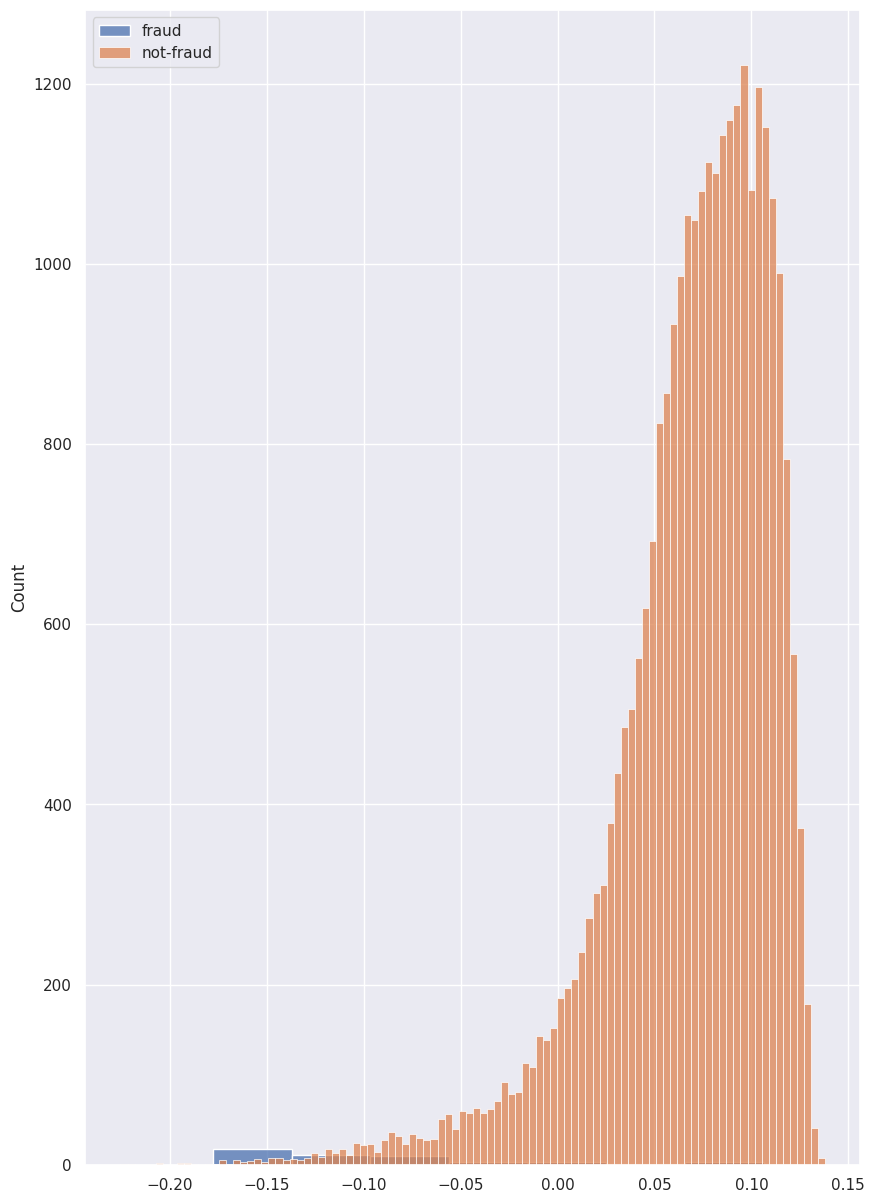

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 15))
sns.histplot(positives_scores, label='fraud', bins=7, ax=ax)
sns.histplot(negatives_scores, label='not-fraud', bins=100, ax=ax)
ax.legend()